In [2]:
def build_model_path(sparsity, beta, threshold):
    sparsity = '0' if sparsity == 0 else sparsity
    threshold = '1' if threshold == 1 else threshold
    return f'./models/experiment_layer_development_investigation/best_grid_search_sparsity_{sparsity}_beta_{beta}_threshold_{threshold}.pth'


# Temporary pruning script

In [10]:
from training.pruning import apply_random_weight_pruning_mask, make_pruning_permanent
from itertools import product
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet

beta = [0.8, 0.99]
threshold = [0.7, 1]
sparsities = [0.2, 0.7, 0.95]

PARAMETER_COMBINATIONS = list(product(beta, threshold, sparsities))

PARAMETER_COMBINATIONS = [(beta, threshold, sparsity) for beta, threshold, sparsity in PARAMETER_COMBINATIONS if not (beta == 0.99 and threshold == 1)]

for (beta, threshold, sparsity) in PARAMETER_COMBINATIONS:
        try:
            base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                                number_hidden_neurons=3000,
                                                                number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                                beta=beta,
                                                                threshold=threshold,
                                                                time_steps=TIME_STEPS,
                                                                number_hidden_layers=2)

            model = copy.deepcopy(base_net)
            model_path = build_model_path(sparsity, beta, threshold)

            model = apply_random_weight_pruning_mask(model, sparsity)
            print(model_path)
            model.load_state_dict(torch.load(model_path))

            model = make_pruning_permanent(model)

            torch.save(model.state_dict(), model_path)
        except:
            print('error')


./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.8_threshold_0.7.pth
error
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.8_threshold_0.7.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.8_threshold_0.7.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.8_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.8_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.8_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.99_threshold_0.7.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.99_threshold_0.7.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.99_threshold_0.7.pth


In [5]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_layer_development_investigation/*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

evaluation = pd.DataFrame(all_dicts)

evaluation["average_training_time_per_epoch"] = evaluation["time"] / evaluation["epochs"]

evaluation = evaluation[(evaluation["beta"] > 0.5) & (evaluation["threshold"] < 3)]

evaluation = (evaluation.sort_values("sparsity", ascending=False))[["epochs", "test_accuracy", "sparsity", "beta", "threshold", "average_training_time_per_epoch"]]

evaluation

,epochs,test_accuracy,sparsity,beta,threshold,average_training_time_per_epoch
4,6,38.515901,0.95,0.99,0.7,822.925837
6,8,39.620141,0.95,0.99,1.0,763.265529
10,56,61.307420,0.95,0.80,1.0,710.448288
21,54,64.045936,0.95,0.80,0.7,719.683757
14,36,65.106007,0.70,0.80,1.0,728.505273
15,14,59.363958,0.70,0.99,0.7,738.234035
11,7,42.005300,0.70,0.99,1.0,771.712926
7,18,63.825088,0.70,0.80,0.7,872.824339
13,8,67.932862,0.20,0.99,0.7,770.564634
19,24,67.314488,0.20,0.80,1.0,742.817294


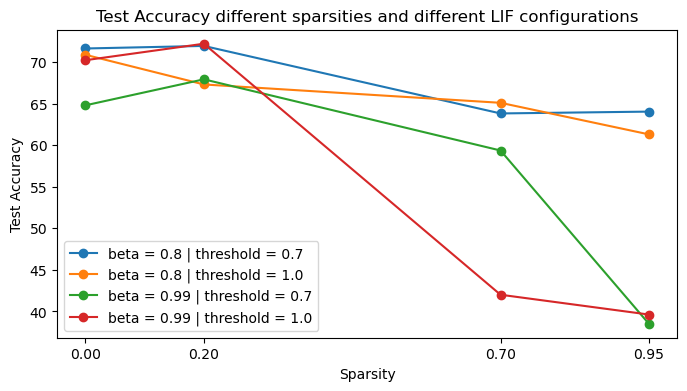

In [6]:
import matplotlib.pyplot as plt

group_y = []
group_labels = []

x = [0, 0.2, 0.7, 0.95]

plt.figure(figsize=(8, 4))

for group_keys, group_df in evaluation.groupby(["beta", "threshold"]):
    group_df = group_df.sort_values("sparsity")
    group_y.append(group_df["test_accuracy"].to_numpy())
    group_labels.append(f'beta = {group_keys[0]} | threshold = {group_keys[1]}')

plt.title("Test Accuracy different sparsities and different LIF configurations")
plt.xlabel("Sparsity")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])

for y, label in zip(group_y, group_labels):
    plt.plot(x,y, marker='o', label=label)

plt.legend()
plt.show()

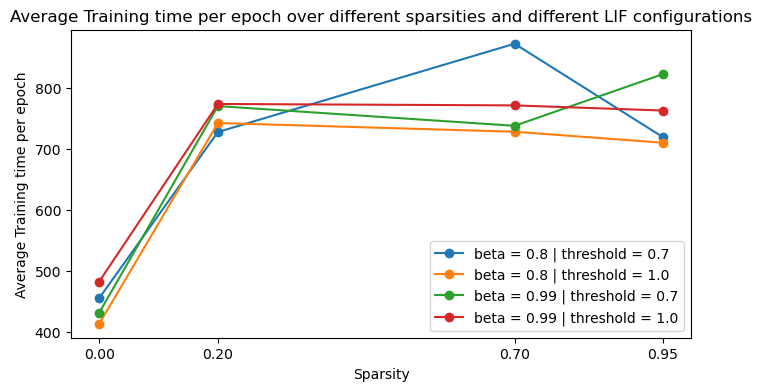

In [7]:
import matplotlib.pyplot as plt

group_y = []
group_labels = []

x = [0, 0.2, 0.7, 0.95]

plt.figure(figsize=(8, 4))

for group_keys, group_df in evaluation.groupby(["beta", "threshold"]):
    group_df = group_df.sort_values("sparsity")
    group_y.append(group_df["average_training_time_per_epoch"].to_numpy())
    group_labels.append(f'beta = {group_keys[0]} | threshold = {group_keys[1]}')

plt.title("Average Training time per epoch over different sparsities and different LIF configurations")
plt.xlabel("Sparsity")
plt.ylabel("Average Training time per epoch")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])

for y, label in zip(group_y, group_labels):
    plt.plot(x,y, marker='o', label=label)

plt.legend()
plt.show()

In [15]:
def count_zeros(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            numel = param.numel()
            zeros = torch.sum(param == 0).item()
            total_params += numel
            zero_params += zeros
    print(f"\nTotal sparsity: {100.0 * zero_params / total_params:.2f}% ({zero_params}/{total_params})")


./models/experiment_layer_development_investigation/best_grid_search_sparsity_0_beta_0.8_threshold_0.7.pth

Total sparsity: 0.00% (0/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.8_threshold_0.7.pth

Total sparsity: 19.99% (2232000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.8_threshold_0.7.pth

Total sparsity: 69.96% (7812000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.8_threshold_0.7.pth

Total sparsity: 94.95% (10602000/11166020)


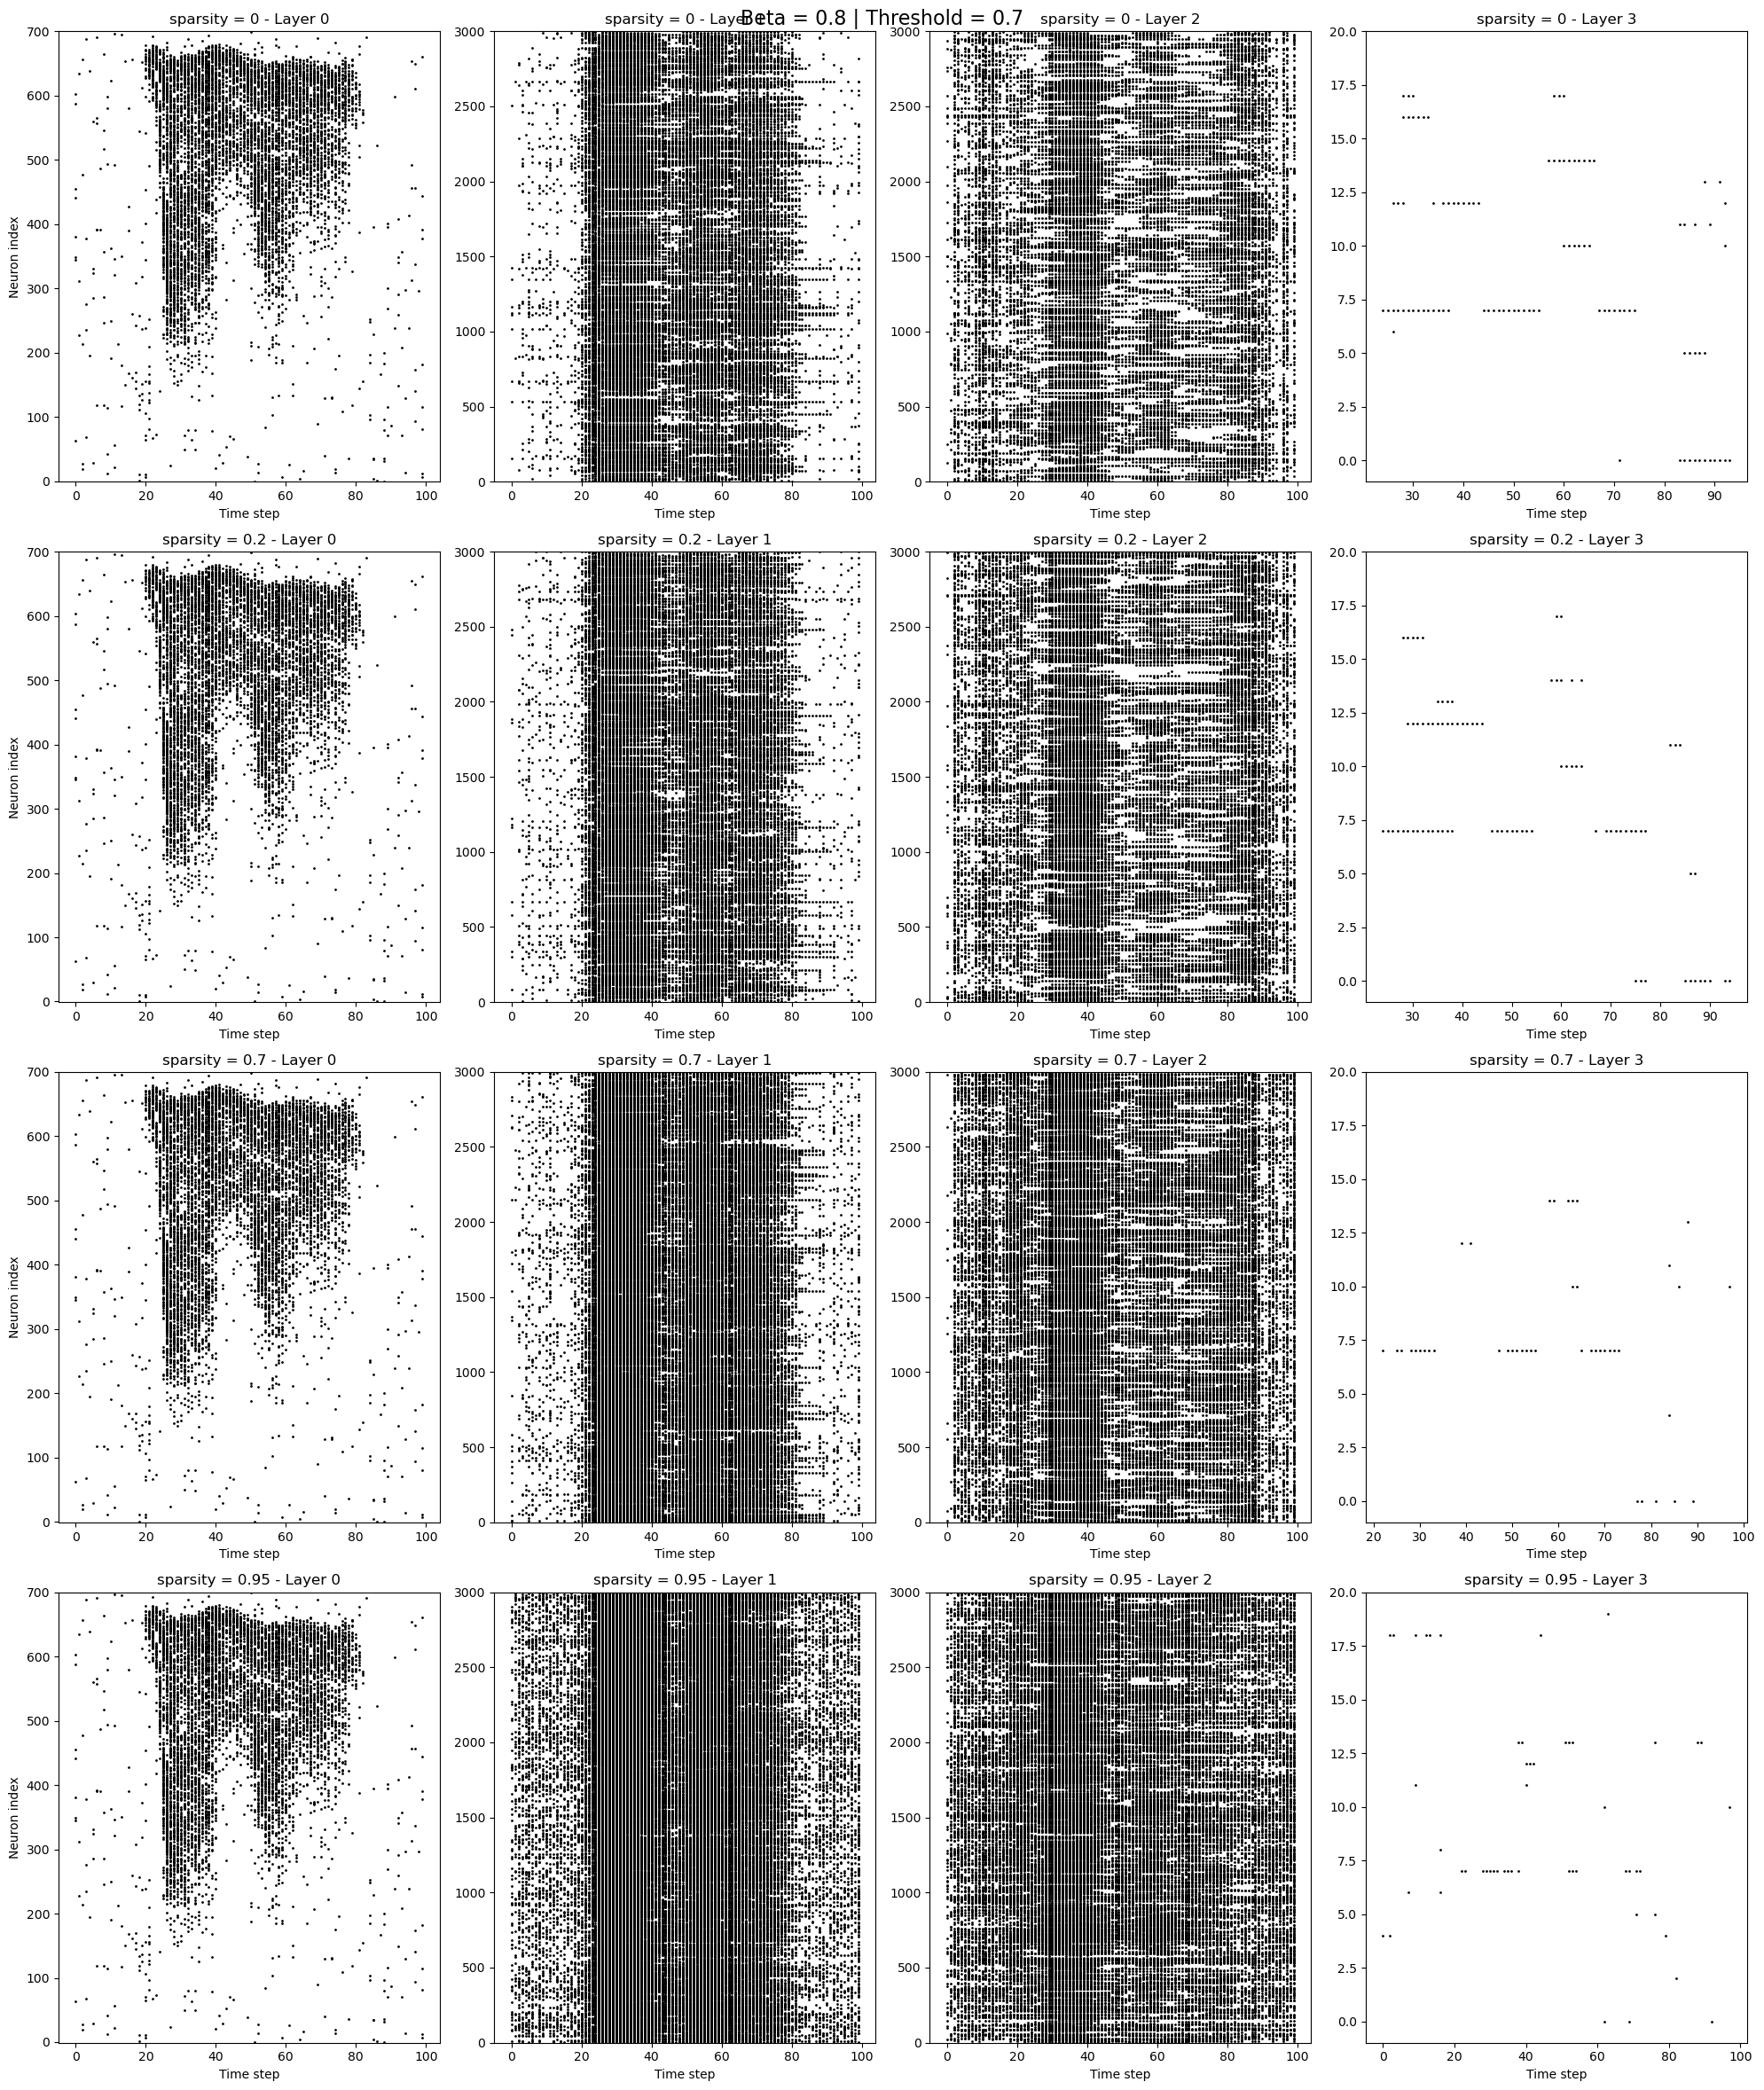

In [16]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.8
threshold = 0.7

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.8 | Threshold = 0.7')

./models/experiment_layer_development_investigation/best_grid_search_sparsity_0_beta_0.8_threshold_1.pth

Total sparsity: 0.00% (0/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.8_threshold_1.pth

Total sparsity: 19.99% (2232000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.8_threshold_1.pth

Total sparsity: 69.96% (7812000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.8_threshold_1.pth

Total sparsity: 94.95% (10602000/11166020)


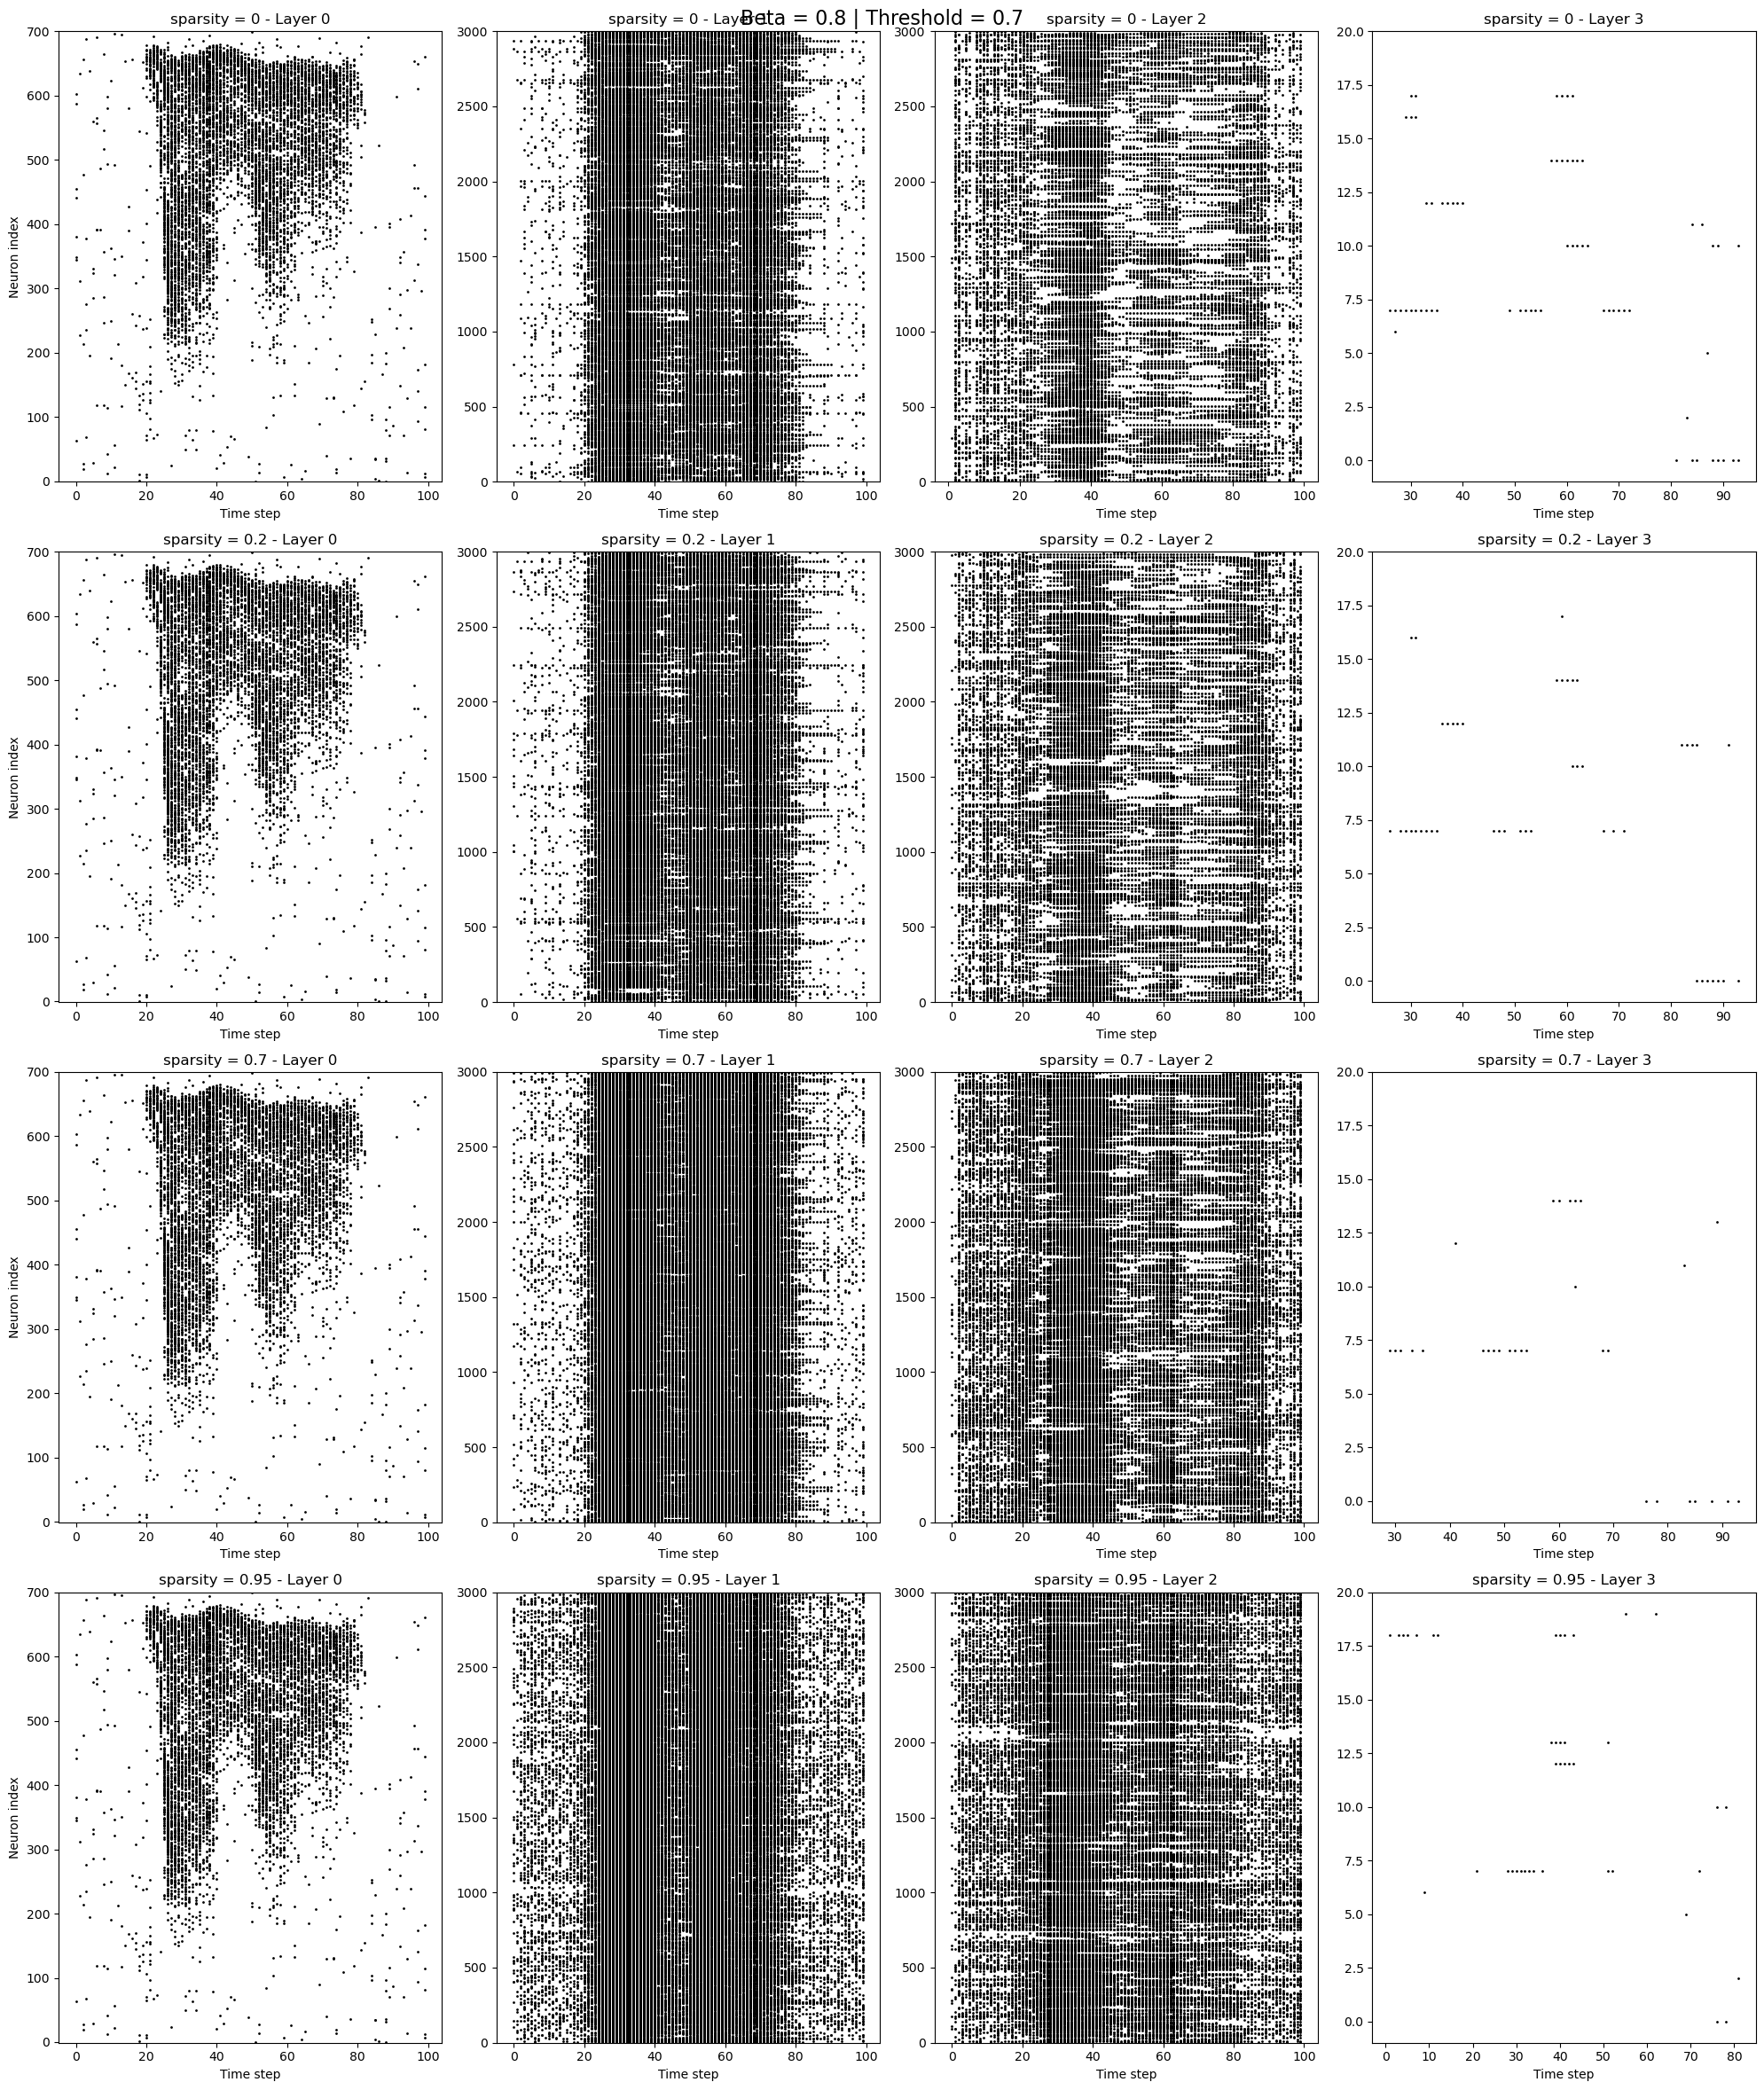

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.8
threshold = 1

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.8 | Threshold = 1')

./models/experiment_layer_development_investigation/best_grid_search_sparsity_0_beta_0.99_threshold_0.7.pth

Total sparsity: 0.00% (0/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.99_threshold_0.7.pth

Total sparsity: 19.99% (2232000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.99_threshold_0.7.pth

Total sparsity: 69.96% (7812000/11166020)
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.99_threshold_0.7.pth

Total sparsity: 94.95% (10602000/11166020)


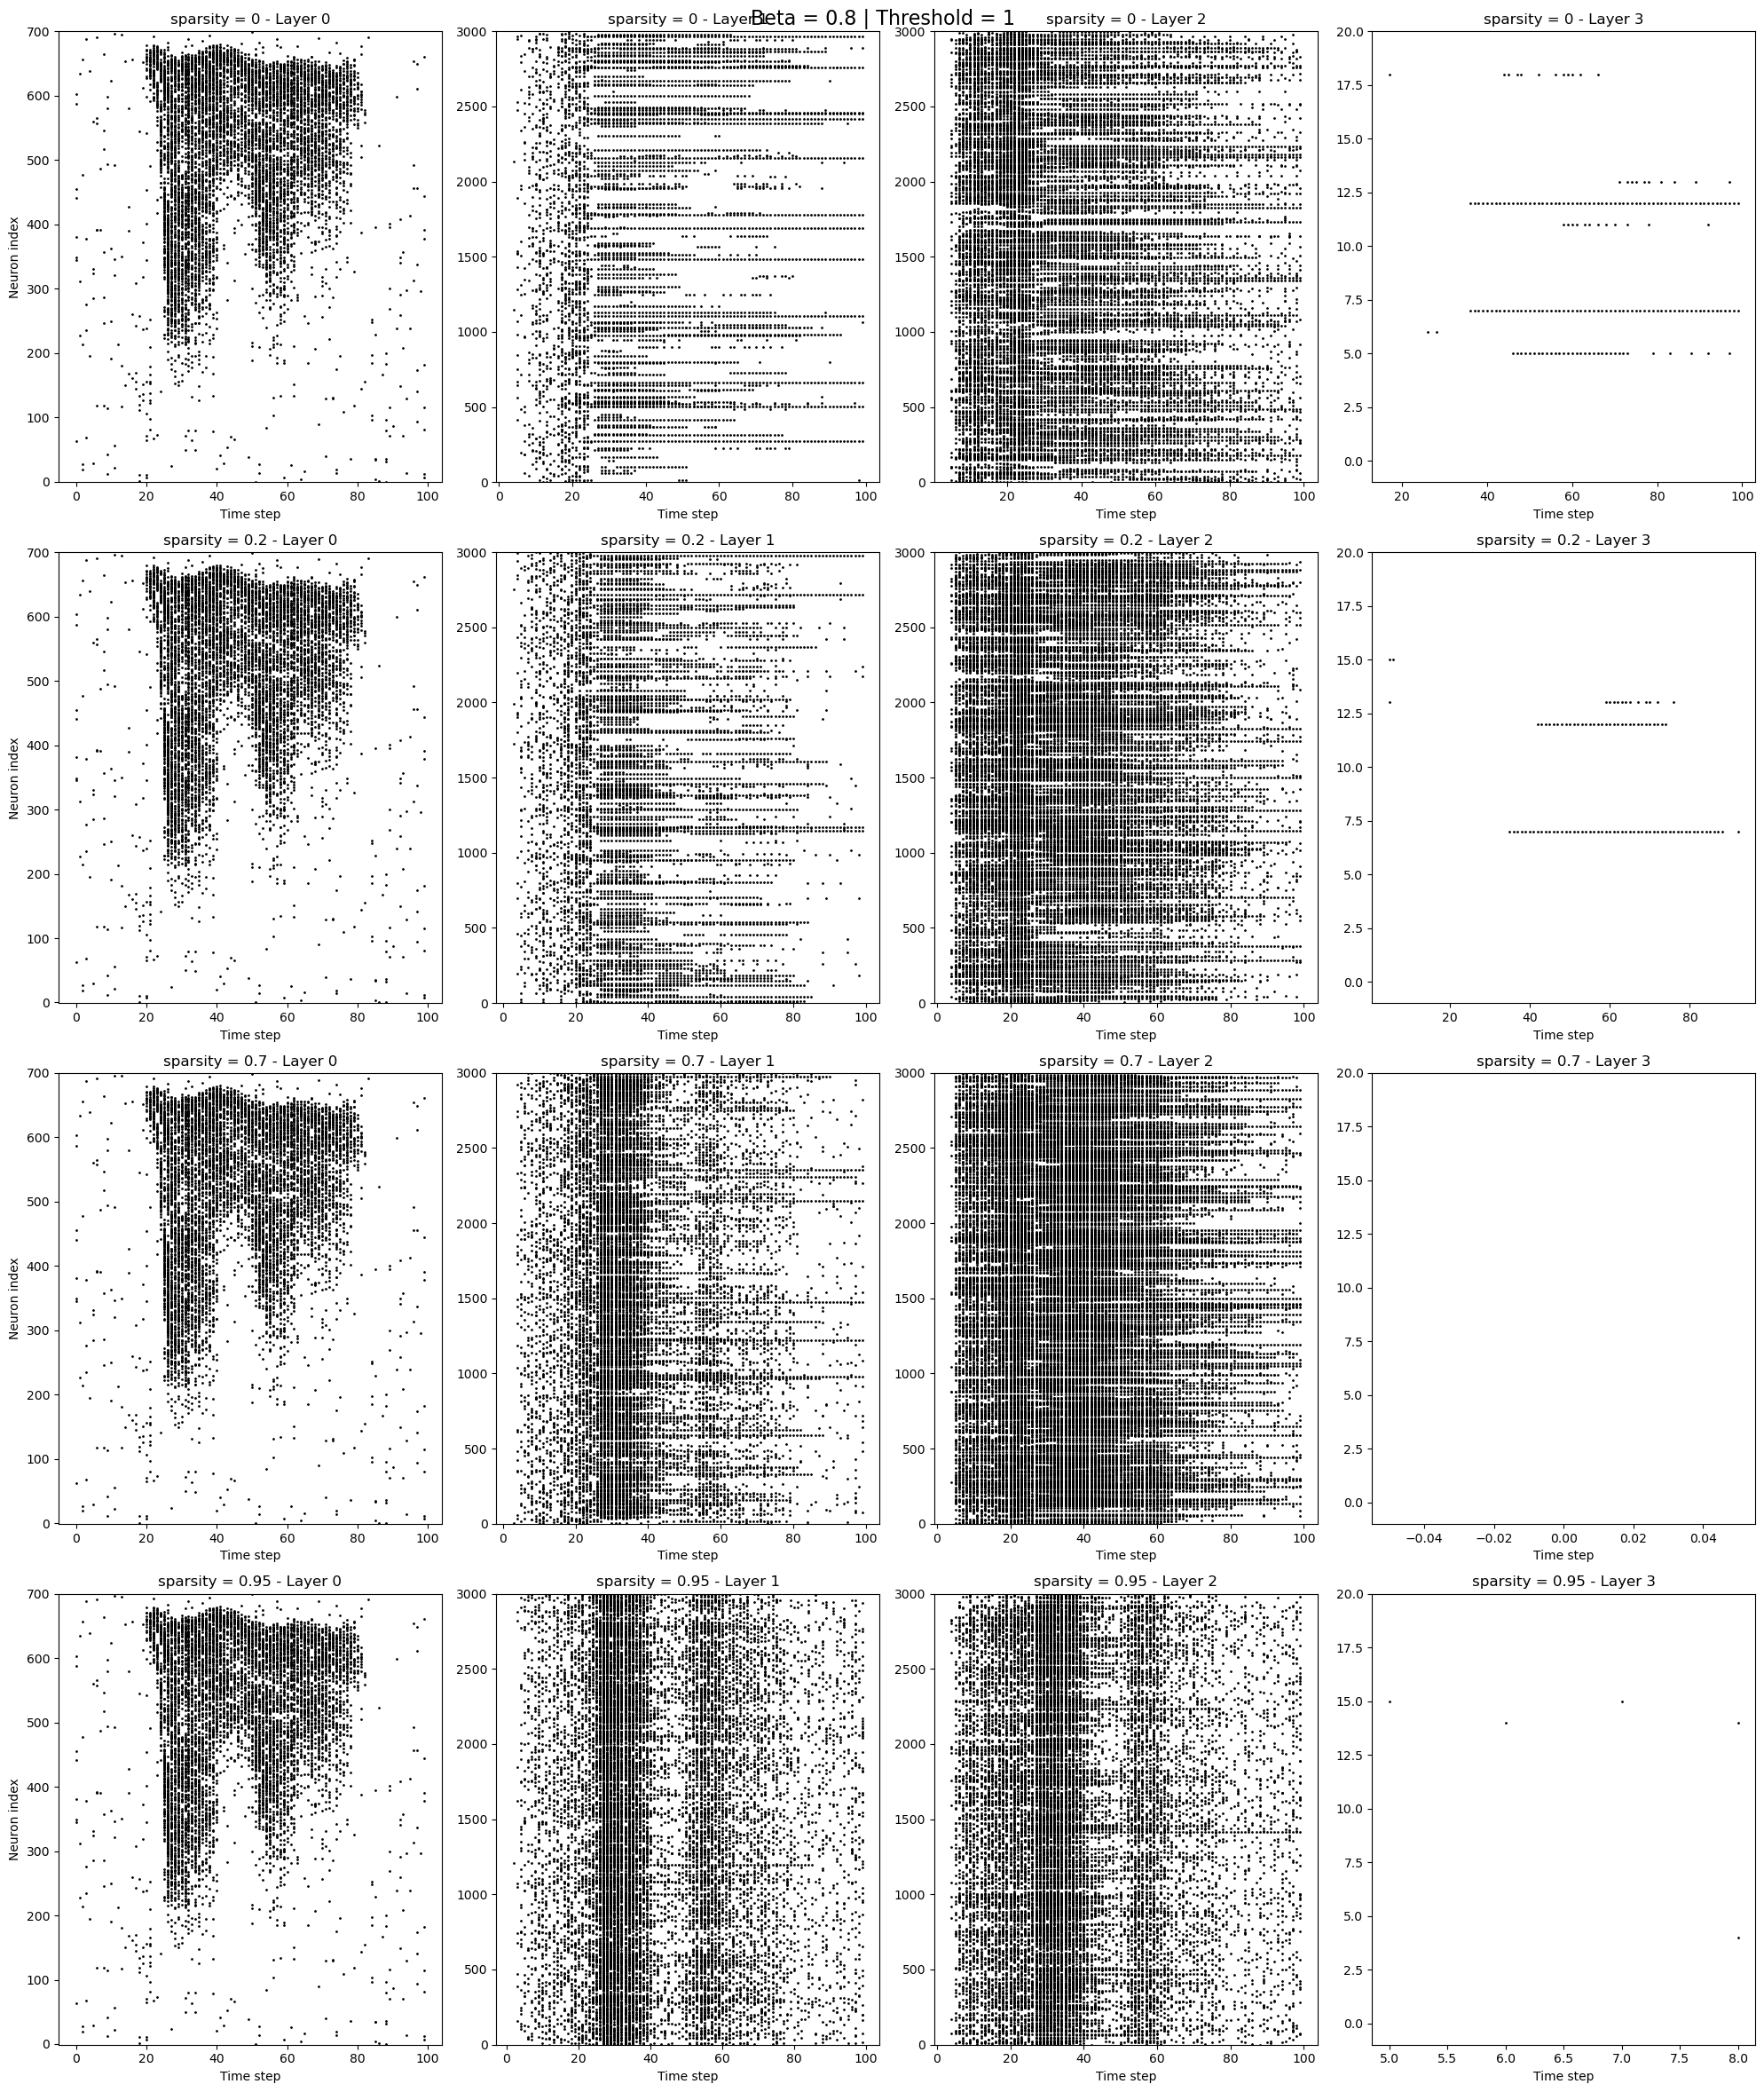

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.99
threshold = 0.7

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.99 | Threshold = 0.7')

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

sparsity = 0

lif_configurations = [
    (0.99, 1),
    (0.99, 0.7),
    (0.8, 1),
    (0.8, 0.7),
]

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

models = []

for beta, threshold in lif_configurations:    
    
    base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                    number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                    number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                    beta=beta,
                                                    threshold=threshold,
                                                    time_steps=TIME_STEPS,
                                                    number_hidden_layers=NUMBER_HIDDEN_LAYER)
    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    models.append(model)

plot_layer_development(models, [f'beta = {beta} | threshold = {threshold}' for beta, threshold in lif_configurations], super_title=f'Sparsity = {sparsity}')